Universidad del Valle de Guatemala

Facultad de Ingeniería

Departamento de Ciencias de la Computación

CC3084 – Data Science

# Laboratorio 5
## Clasificación de tweets usando minería de texto

Daniel Valdez - 21240

Emilio Solano - 21212

In [25]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



### Carga y descripción de datos


#### Evaluación del dataset

In [26]:
df = pd.read_csv('train.csv')

In [27]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [29]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Verificar y tratar valores nulos

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


<Axes: >

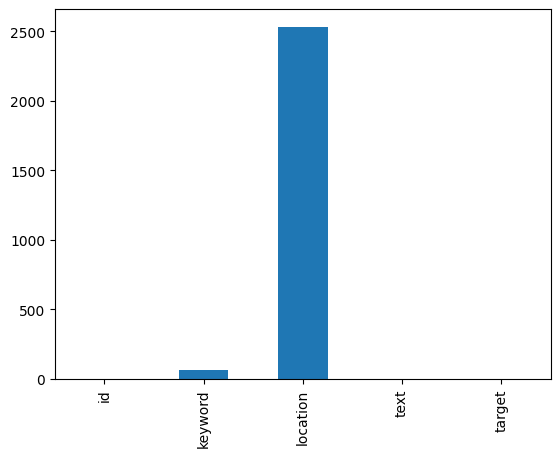

In [30]:
print(df.isnull().sum())
# Show into a graph how percentage of missing values in each column
df.isnull().sum().plot(kind='bar')

In [31]:
df['keyword'].fillna('', inplace=True)
df['location'].fillna('Unknown', inplace=True)

In [32]:
df.head()

,id,keyword,location,text,target
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocesamiento de datos

#### Limpieza

In [33]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Convertir a minúsculas
df['cleaned_text'] = df['text'].str.lower()

# Eliminar URLs
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar menciones, hashtags, caracteres especiales y números
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'@\w+|#\w+|\W|\d+', ' ', x))

# Eliminar stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
from textblob import TextBlob

# Función para obtener el sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Aplicar la función a los tweets
df['sentiment'] = df['cleaned_text'].apply(get_sentiment)
df.head(10)

,id,keyword,location,text,target,cleaned_text,sentiment
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,0.0000
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,0.1000
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,-0.1000
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california,0.0000
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,0.0000
5,8,,Unknown,#RockyFire Update => California Hwy. 20 closed...,1,update california hwy closed directions due la...,-0.1125
6,10,,Unknown,#flood #disaster Heavy rain causes flash flood...,1,heavy rain causes flash flooding streets manit...,-0.2000
7,13,,Unknown,I'm on top of the hill and I can see a fire in...,1,top hill see fire woods,0.5000
8,14,,Unknown,There's an emergency evacuation happening now ...,1,emergency evacuation happening building across...,0.0000
9,15,,Unknown,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area,-0.6000


<Axes: title={'center': 'sentiment'}, xlabel='target'>

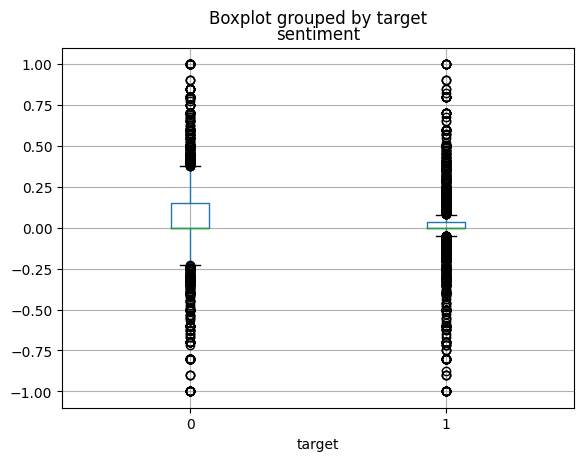

In [35]:
# Graph sentiment on boxplot for category on target
df.boxplot(column='sentiment', by='target')

In [36]:

# Descargar WordNet si no está disponible
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Aplicar la lematización
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
# Mostrar las primeras filas del texto limpiado
df['cleaned_text'].head()

,cleaned_text
0,deed reason may allah forgive u
1,forest fire near la ronge sask canada
2,resident asked shelter place notified officer ...
3,people receive evacuation order california
4,got sent photo ruby smoke pours school


#### Análisis de frecuencia

In [38]:
# Unigramas
disaster_words = ' '.join(df[df['target'] == 1]['cleaned_text']).split()
nondisaster_words = ' '.join(df[df['target'] == 0]['cleaned_text']).split()

disaster_freq = Counter(disaster_words)
nondisaster_freq = Counter(nondisaster_words)

In [39]:
disaster_freq.most_common(10)

[('fire', 265),
 ('û_', 172),
 ('amp', 135),
 ('via', 121),
 ('disaster', 113),
 ('year', 112),
 ('suicide', 112),
 ('california', 111),
 ('police', 108),
 ('u', 106)]

In [40]:
nondisaster_freq.most_common(10)

[('like', 255),
 ('amp', 209),
 ('get', 185),
 ('û_', 172),
 ('new', 170),
 ('u', 150),
 ('one', 137),
 ('body', 118),
 ('time', 106),
 ('day', 102)]

### Análisis exploratorio

#### Nube de palabras

Nube de palabras para tweets de desastres


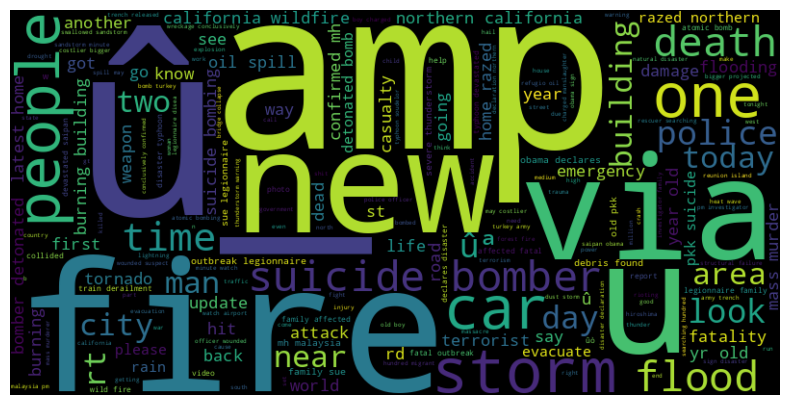

Nube de palabras para tweets no relacionados con desastres


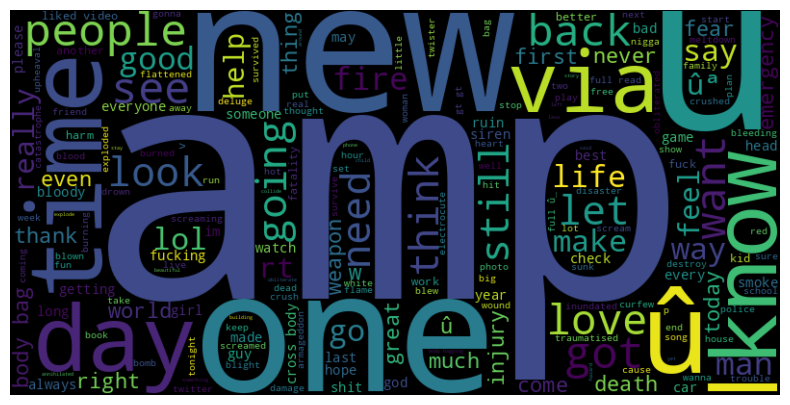

In [41]:
print('Nube de palabras para tweets de desastres')
disaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(disaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print('Nube de palabras para tweets no relacionados con desastres')
nondisaster_wordcloud = WordCloud(width=800, height=400).generate(' '.join(nondisaster_words))
plt.figure(figsize=(10, 5))
plt.imshow(nondisaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Histogramas de frecuencia

Histograma de palabras más frecuentes
Plot histogram


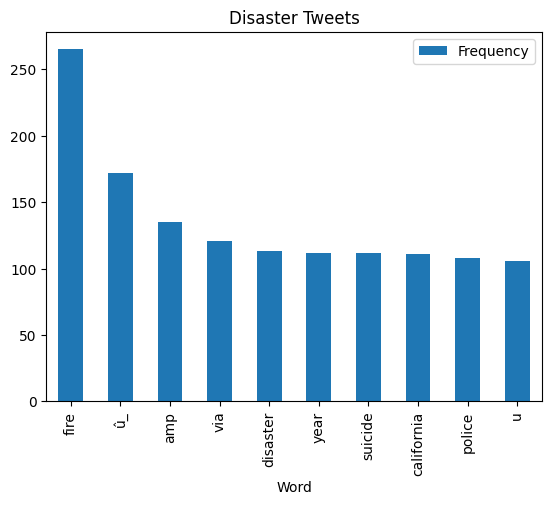

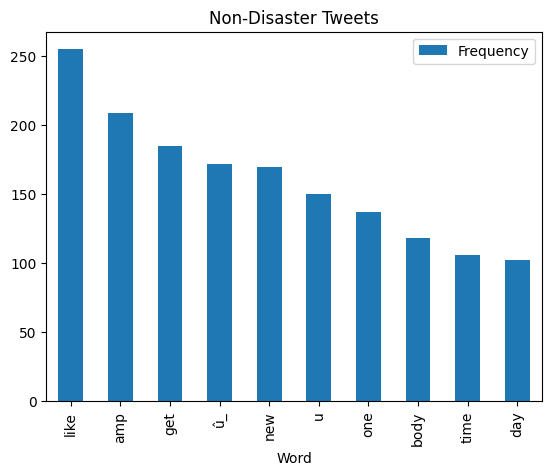

In [42]:
print('Histograma de palabras más frecuentes')
disaster_common_words = disaster_freq.most_common(10)
nondisaster_common_words = nondisaster_freq.most_common(10)

disaster_df = pd.DataFrame(disaster_common_words, columns=['Word', 'Frequency'])
nondisaster_df = pd.DataFrame(nondisaster_common_words, columns=['Word', 'Frequency'])

print('Plot histogram')
disaster_df.plot(kind='bar', x='Word', y='Frequency', title='Disaster Tweets')
nondisaster_df.plot(kind='bar', x='Word', y='Frequency', title='Non-Disaster Tweets')
plt.show()

In [43]:
# Lista de palabras clave relacionadas con desastres
disaster_keywords = ['fire', 'disaster', 'police', 'suicide']

# Crear columnas binarias para cada palabra clave
for keyword in disaster_keywords:
    df[f'contains_{keyword}'] = df['cleaned_text'].apply(lambda x: 1 if keyword in x else 0)

# Mostrar las primeras filas del DataFrame con las columnas binarias
df.head()

,id,keyword,location,text,target,cleaned_text,sentiment,contains_fire,contains_disaster,contains_police,contains_suicide
0,1,,Unknown,Our Deeds are the Reason of this #earthquake M...,1,deed reason may allah forgive u,0.0,0,0,0,0
1,4,,Unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,0.1,1,0,0,0
2,5,,Unknown,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...,-0.1,0,0,0,0
3,6,,Unknown,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation order california,0.0,0,0,0,0
4,7,,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,0.0,0,0,0,0


In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import pandas as pd

# Crear el vectorizador de Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Crear el vectorizador para bi-gramas con un rango menor para reducir la dimensionalidad
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))  # Cambiado de (2, 3) a (2, 2)
X_ngrams = ngram_vectorizer.fit_transform(df['cleaned_text'])

# Verifica las formas de las matrices
print("Bag of Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)
print("N-grams shape:", X_ngrams.shape)

# Concatenar las matrices dispersas
X_combined = hstack([X_bow, X_tfidf, X_ngrams], format='csr')

# Obtener nombres de características (se usa solo para debug, no para el DataFrame final)
bow_features = bow_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()
ngram_features = ngram_vectorizer.get_feature_names_out()

# Verificar la longitud de cada conjunto de características
print("Number of features from Bag of Words:", len(bow_features))
print("Number of features from TF-IDF:", len(tfidf_features))
print("Number of features from N-grams:", len(ngram_features))


# Convertir características adicionales a una matriz dispersa
additional_features = df[[f'contains_{keyword}' for keyword in disaster_keywords]].values
additional_features_sparse = csr_matrix(additional_features)

# Concatenar características adicionales con las características combinadas
X_combined = hstack([X_combined, additional_features_sparse], format='csr')

# Preparar datos para el modelo
from sklearn.model_selection import train_test_split

X = X_combined
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Bag of Words shape: (7613, 11627)
TF-IDF shape: (7613, 11627)
N-grams shape: (7613, 41017)
Number of features from Bag of Words: 11627
Number of features from TF-IDF: 11627
Number of features from N-grams: 41017


### Modelo preliminar (Regresión logística)

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1318
           1       0.81      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



<Axes: >

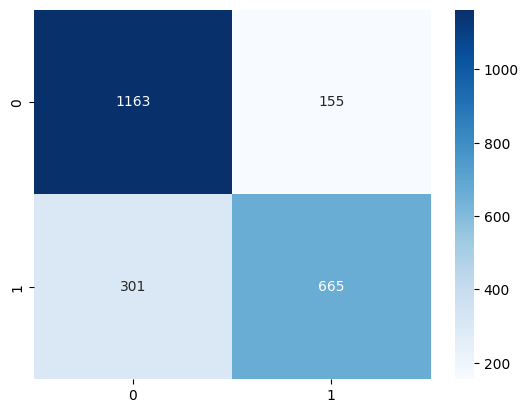

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Entrenar un modelo preliminar
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrix of confution
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


Accuracy: 0.7902802101576182
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1318
           1       0.75      0.75      0.75       966

    accuracy                           0.79      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.79      0.79      0.79      2284



<Axes: >

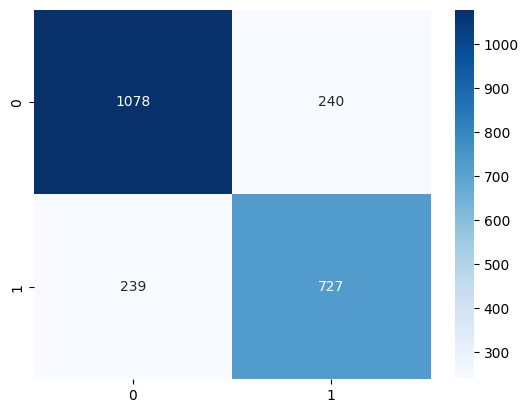

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7845884413309983
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1318
           1       0.77      0.70      0.73       966

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.78      2284
weighted avg       0.78      0.78      0.78      2284



<Axes: >

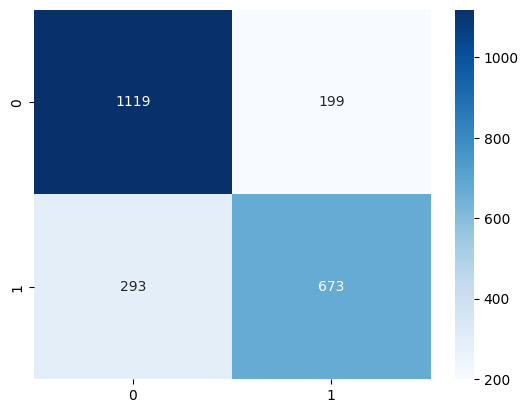

In [50]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Accuracy: 0.7810858143607706
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82      1318
           1       0.81      0.63      0.71       966

    accuracy                           0.78      2284
   macro avg       0.79      0.76      0.77      2284
weighted avg       0.78      0.78      0.78      2284



<Axes: >

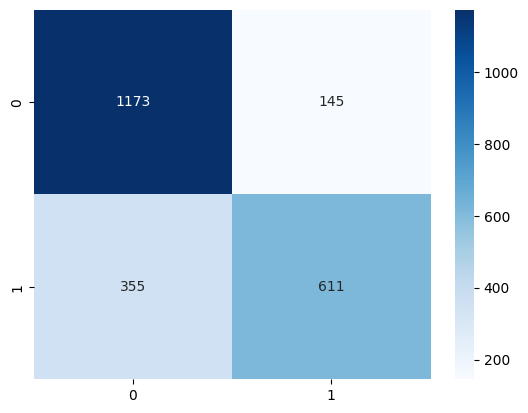

In [51]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Best parameters found: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
Best cross-validation score: 0.7847624835945
Test Accuracy: 0.7863397548161121
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      1318
           1       0.78      0.69      0.73       966

    accuracy                           0.79      2284
   macro avg       0.78      0.77      0.78      2284
weighted avg       0.79      0.79      0.78      2284



<Axes: >

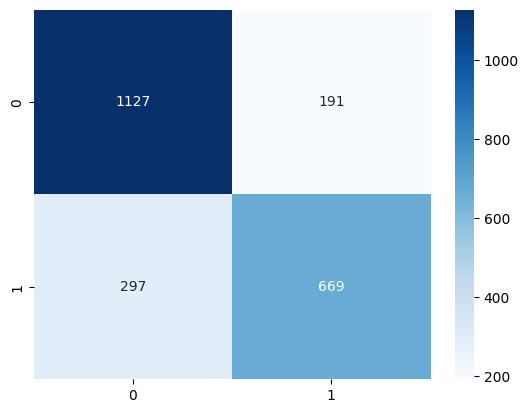

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Definir el clasificador Naive Bayes
nb = MultinomialNB()

# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Ejemplos de valores para la suavización de Laplace
    'fit_prior': [True, False],  # Ejemplos de valores para ajustar la distribución previ
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]], # Ejemplos de valores para la distribución a priori
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar GridSearchCV a los datos
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Best parameters found:", grid_search.best_params_)

# Imprimir la mejor puntuación obtenida
print("Best cross-validation score:", grid_search.best_score_)

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6594 - loss: 0.6961 - val_accuracy: 0.7467 - val_loss: 0.5608
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9619 - loss: 0.1199 - val_accuracy: 0.7223 - val_loss: 0.6414
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9814 - loss: 0.0612 - val_accuracy: 0.7223 - val_loss: 0.6441
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9837 - loss: 0.0469 - val_accuracy: 0.7326 - val_loss: 0.6238
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9830 - loss: 0.0362 - val_accuracy: 0.7298 - val_loss: 0.6395
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9851 - loss: 0.0333 - val_accuracy: 0.7392 - val_loss: 0.6491
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9824 - loss: 0.0353 - val_accuracy: 0.7402 - val_loss: 0.6567
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9877 - loss: 0.0253 - val_ac

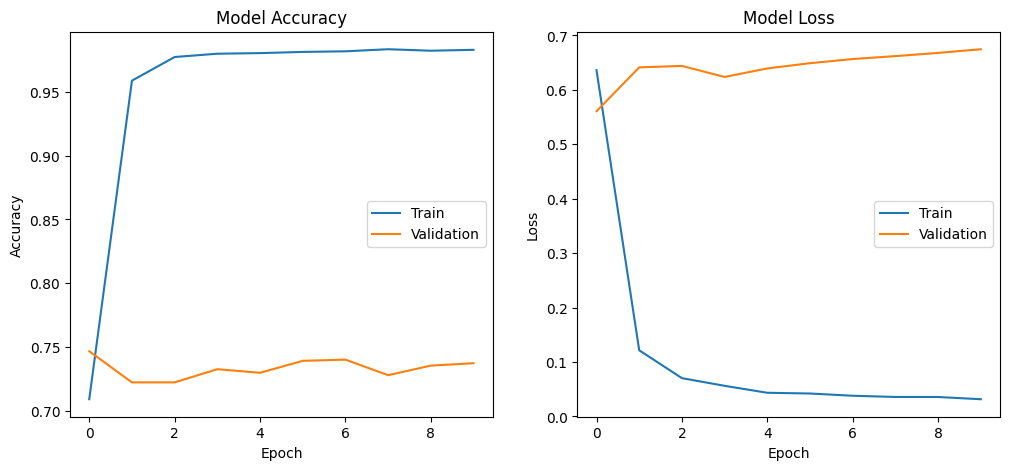

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Supongamos que X_combined y y están definidos como en el código anterior

# Escalar características (opcional, pero recomendado para redes neuronales)
scaler = StandardScaler(with_mean=False)  # with_mean=False para matrices dispersas
X_scaled = scaler.fit_transform(X_combined)

# Convertir y a formato de clasificación binaria (one-hot encoding)
y_categorical = to_categorical(y)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta con 64 neuronas
model.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas (para clasificación binaria)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Opcional: Graficar la evolución de la precisión y pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6403 - loss: 0.9934 - val_accuracy: 0.7683 - val_loss: 0.9814
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8350 - loss: 0.9650 - val_accuracy: 0.7411 - val_loss: 1.0414
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9223 - loss: 0.7303 - val_accuracy: 0.7458 - val_loss: 0.9910
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9422 - loss: 0.6373 - val_accuracy: 0.7477 - val_loss: 0.9688
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9613 - loss: 0.5341 - val_accuracy: 0.7420 - val_loss: 0.9659
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9613 - loss: 0.5045 - val_accuracy: 0.7514 - val_loss: 0.9774
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9671 - loss: 0.5006 - val_accuracy: 0.7664 - val_loss: 0.9486
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9631 - loss: 0.4978 - val_

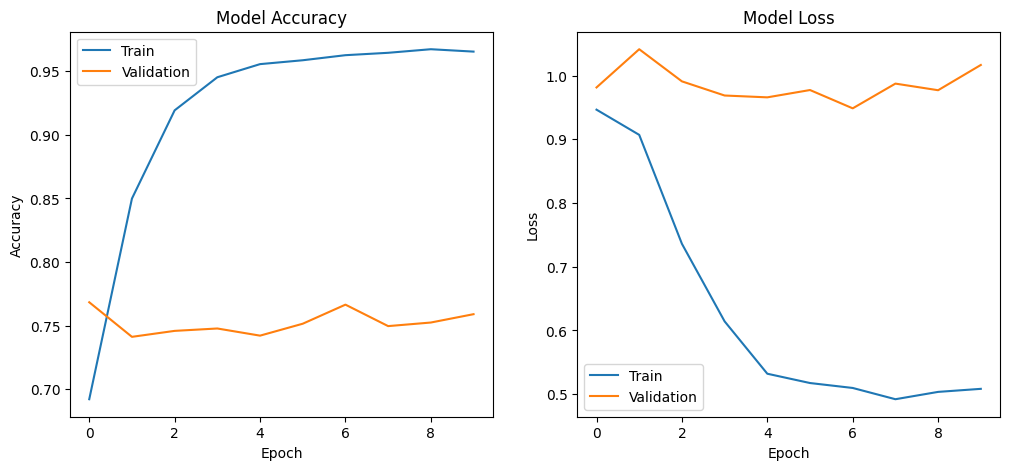

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))  # Capa oculta con regularización L2
model.add(Dropout(0.3))  # Dropout con probabilidad del 30%
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))  # Capa oculta con regularización L2
model.add(Dropout(0.3))  # Dropout con probabilidad del 30%
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas (para clasificación binaria)


# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Opcional: Graficar la evolución de la precisión y pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.5068 - loss: 1.1372 - val_accuracy: 0.6266 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6091 - loss: 0.9670 - val_accuracy: 0.6510 - val_loss: 1.0065 - learning_rate: 0.0010
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6219 - loss: 1.0006 - val_accuracy: 0.6201 - val_loss: 1.0458 - learning_rate: 0.0010
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6613 - loss: 0.9661 - val_accuracy: 0.6567 - val_loss: 0.9982 - learning_rate: 5.0000e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6959 - loss: 0.8950 - val_accuracy: 0.7251 - val_loss: 0.9519 - learning_rate: 5.0000e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7298 - loss: 0.8223 - val_accuracy: 0.7270 - val_loss: 0.9185 - learning_rate: 2.5000e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.74

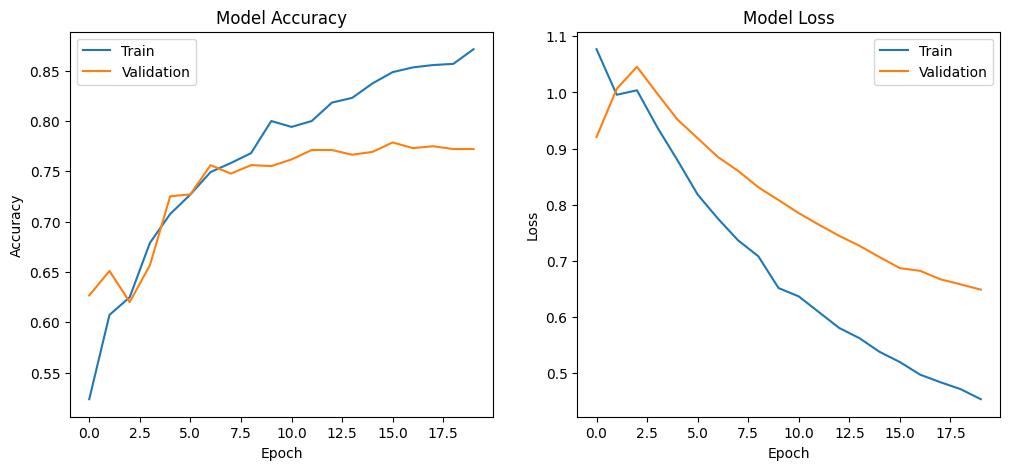

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

# Supongamos que X_combined y y están definidos como en el código anterior

# Escalar características
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)

# Convertir y a formato de clasificación binaria
y_categorical = to_categorical(y)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))  # Capa oculta con menos neuronas
model.add(Dropout(0.5))  # Dropout con probabilidad del 50%
model.add(BatchNormalization())  # Normalización por lotes
model.add(Dense(8, activation='relu', kernel_regularizer='l2'))  # Capa oculta con menos neuronas
model.add(Dropout(0.5))  # Dropout con probabilidad del 50%
model.add(BatchNormalization())  # Normalización por lotes
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas (para clasificación binaria)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar Early Stopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Graficar la evolución de la precisión y pérdida durante el entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()
